For each protein sequence, separate graphs are created with nodea as amino acids and the edge weights are combination of both spatial distance and protein similarity from ProtBERT embeddings.
ProtBERT embeddings passed as node features for each tokenized amino acid in the separate graphs.
Spatial distances calculated with Manhattan distance and there is a threshold for the distance if two amino acids are connected in a spatial way or not.

In [2]:
import networkx as nx
from Bio.PDB import PDBParser
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cosine

/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")

In [4]:
def get_residue_embeddings(sequence):
   
    tokenized_seq = " ".join(list(sequence))
    inputs = tokenizer(tokenized_seq, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_state = outputs.last_hidden_state

    embeddings = last_hidden_state[0, 1:-1].cpu().numpy()
    
    return embeddings

In [5]:
def create_enhanced_protein_graph(pdb_file, sequence, distance_threshold=10.0, embedding_weight=0.5):
  
    residue_embeddings = get_residue_embeddings(sequence)
    
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    G = nx.Graph()
    
    aa_dict = {
        'A': 'ALA', 'R': 'ARG', 'N': 'ASN', 'D': 'ASP', 
        'C': 'CYS', 'E': 'GLU', 'Q': 'GLN', 'G': 'GLY', 
        'H': 'HIS', 'I': 'ILE', 'L': 'LEU', 'K': 'LYS', 
        'M': 'MET', 'F': 'PHE', 'P': 'PRO', 'S': 'SER', 
        'T': 'THR', 'W': 'TRP', 'Y': 'TYR', 'V': 'VAL'
    }
    
    residue_list = []
    residue_to_seq_idx = {} 
    
    for model in structure:
        for chain in model:
            seq_idx = 0  # Index in the sequence
            for residue in chain:
                if 'CA' in residue:
                    residue_id = residue.get_id()[1]  # Residue number
                    residue_name = residue.get_resname()  # Amino acid type (3-letter code)
                    coords = residue['CA'].get_coord()  # CA atom coordinates
                    
                    # Get the corresponding embedding if available
                    if seq_idx < len(residue_embeddings):
                        embedding = residue_embeddings[seq_idx]
                    else:
                        embedding = np.zeros(1024) 
            
                    G.add_node(residue_id, 
                              residue_name=residue_name,
                              coords=coords,
                              position=seq_idx,
                              embedding=embedding,
                              one_letter=sequence[seq_idx] if seq_idx < len(sequence) else 'X')
                    
                    residue_list.append((residue_id, coords))
                    residue_to_seq_idx[residue_id] = seq_idx
                    seq_idx += 1
    
    # edges with combined weights (spatial + embedding similarity)
    for i, (res_i, coord_i) in enumerate(residue_list):
        for j, (res_j, coord_j) in enumerate(residue_list[i+1:], i+1):

            spatial_distance = np.linalg.norm(coord_i - coord_j) # Manhattan distance as a spatial dist
            
            if spatial_distance < distance_threshold:
        
                emb_i = G.nodes[res_i]['embedding']
                emb_j = G.nodes[res_j]['embedding']
                
                # embedding similarity (1 - cosine distance)
                # Higher value means more similar
                emb_similarity = 1.0 - cosine(emb_i, emb_j)
                
                norm_distance = spatial_distance / distance_threshold
            
                # Lower weight means stronger connection
                combined_weight = (1 - embedding_weight) * norm_distance + embedding_weight * (1 - emb_similarity)
                
                G.add_edge(res_i, res_j, 
                          spatial_distance=spatial_distance,
                          embedding_similarity=emb_similarity,
                          weight=combined_weight)
    
    G.graph['sequence'] = sequence
    G.graph['global_embedding'] = residue_embeddings.mean(axis=0)
    
    return G, residue_list

In [6]:
def visualize_enhanced_protein_graph(G, residue_list, title="Enhanced Protein Graph"):

    plt.figure(figsize=(14, 12))
    
    pos = {res_id: (coord[0], coord[1]) for res_id, coord in residue_list}
    
    node_labels = {node: f"{node}\n{G.nodes[node]['residue_name']}\n({G.nodes[node]['one_letter']})" 
                  for node in G.nodes()}
    
    edge_labels = {(u, v): f"D:{G[u][v]['spatial_distance']:.1f}\nS:{G[u][v]['embedding_similarity']:.2f}" 
                  for u, v in G.edges()}
    
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', alpha=0.8)
    
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.7, edge_color=edge_colors, edge_cmap=plt.cm.Blues_r)
    
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    print(f"Node embedding dimension: {G.nodes[list(G.nodes())[0]]['embedding'].shape}")

In [7]:
def process_pdb_directory(pdb_dir, sequences_dict, output_dir=None, distance_threshold=10.0, embedding_weight=0.5):
   
    graphs = {}
    
    for filename in os.listdir(pdb_dir):
        if filename.endswith('.pdb'):
            # protein ID from filename
            protein_id = filename.split('_')[0]  
            
            if protein_id in sequences_dict:
                sequence = sequences_dict[protein_id]
                pdb_path = os.path.join(pdb_dir, filename)
                
                print(f"Processing {protein_id}...")
              
                graph, _ = create_enhanced_protein_graph(
                    pdb_path, 
                    sequence, 
                    distance_threshold=distance_threshold,
                    embedding_weight=embedding_weight
                )
                
                graphs[protein_id] = graph
                
                if output_dir:
                    os.makedirs(output_dir, exist_ok=True)
                    nx.write_gpickle(graph, os.path.join(output_dir, f"{protein_id}_graph.gpickle"))
            else:
                print(f"Warning: No sequence found for {protein_id}")
    
    return graphs

Length of the protein seq: 109


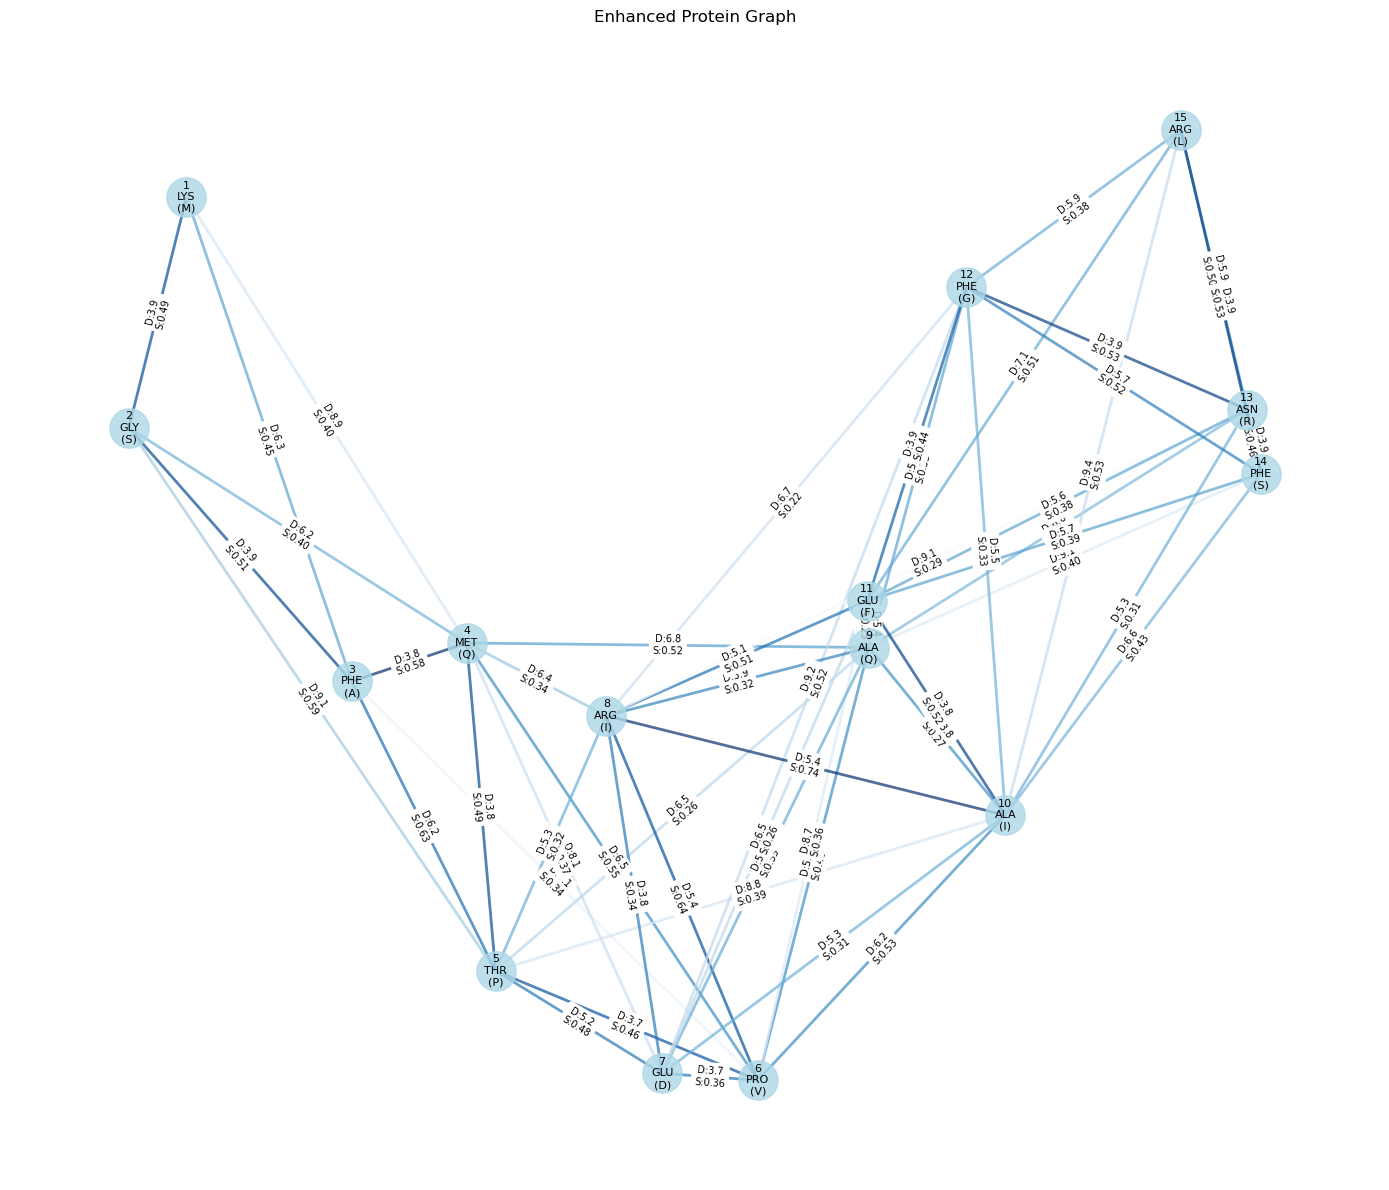

Number of nodes: 15
Number of edges: 54
Average degree: 7.20
Node embedding dimension: (1024,)


In [12]:
pdb_file = "example_pdb_files/allergen_3552_unrelaxed_rank_004_alphafold2_ptm_model_1_seed_000.pdb"  
protein_sequence = "MSAQPVDIQIFGRSLRVNCPPDQRDALNQAADDLNQRLQDLKERTRVTNTEQLVFIAALNISYELAQEKAKTRDYAASMEQRIRMLQQTIEQALLEQGRITEKTNQNFE" 
print(f"Length of the protein seq: {len(protein_sequence)}")

G, residue_list = create_enhanced_protein_graph(pdb_file, protein_sequence)

visualize_enhanced_protein_graph(G, residue_list)

In [1]:
from Bio.PDB import PDBParser

parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", "example_pdb_files/allergen_3552_unrelaxed_rank_004_alphafold2_ptm_model_1_seed_000.pdb" )
residue_count = 0
for model in structure:
    for chain in model:
        for residue in chain:
            if 'CA' in residue:
                residue_count += 1
print(f"PDB file contains {residue_count} residues with CA atoms")

PDB file contains 15 residues with CA atoms


Length of the protein seq: 64


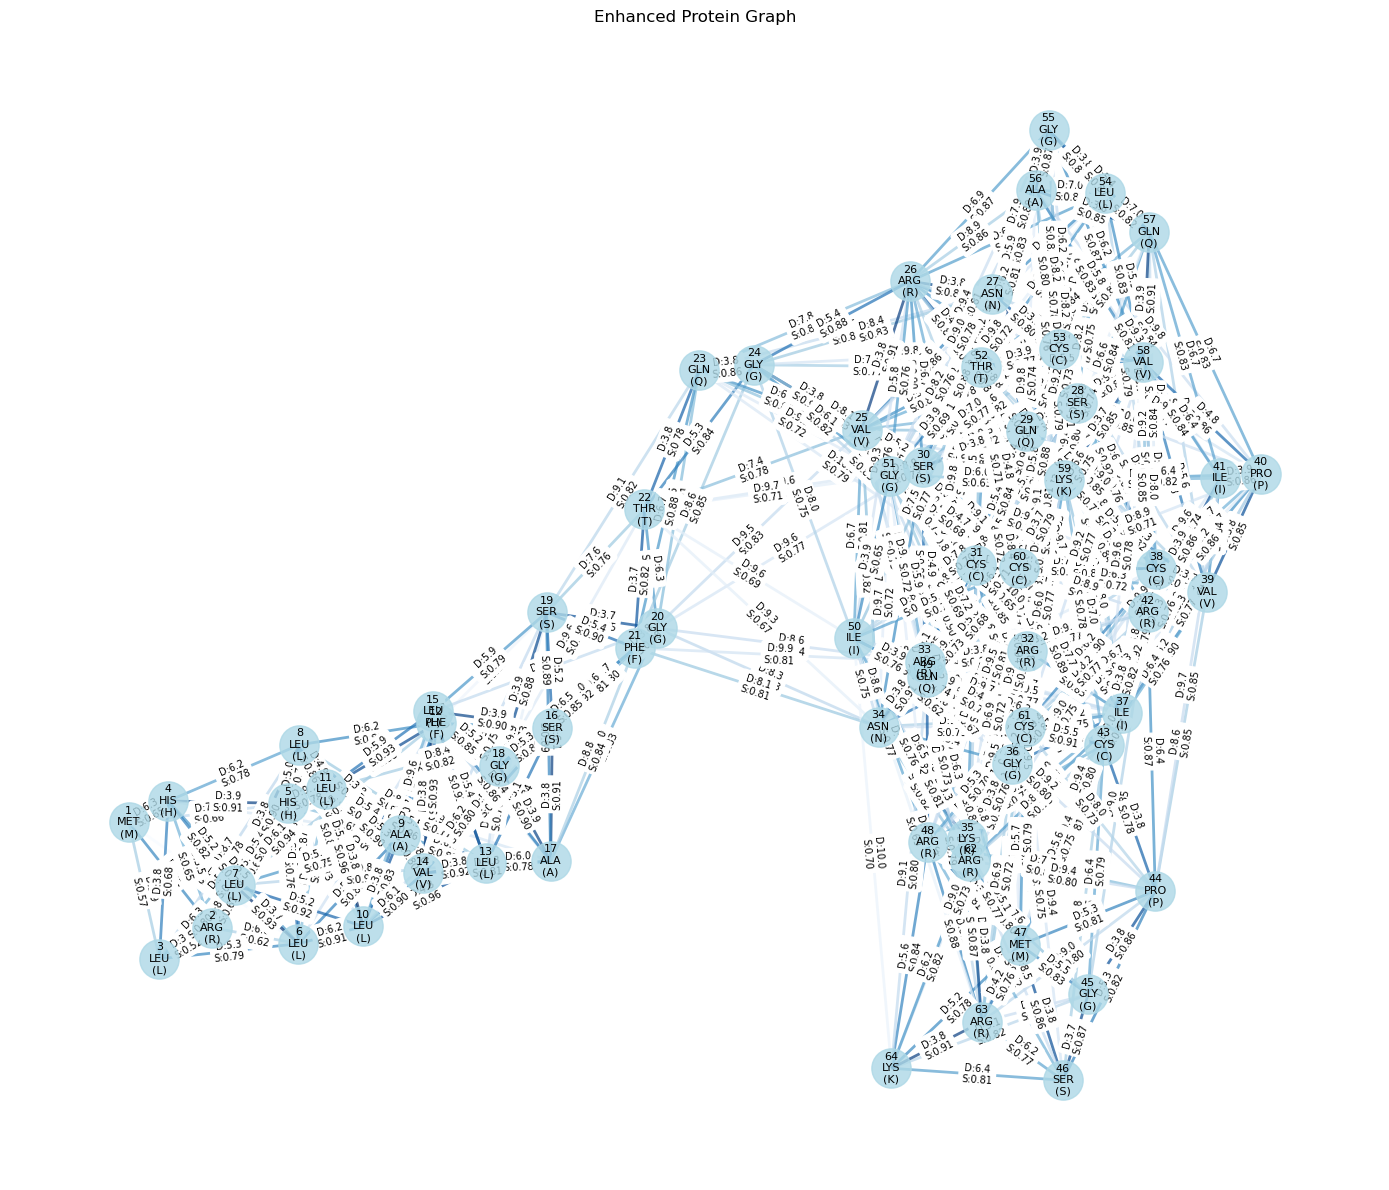

Number of nodes: 64
Number of edges: 480
Average degree: 15.00
Node embedding dimension: (1024,)


In [11]:
pdb_file = "example_pdb_files/non-allergen_31963_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"  
protein_sequence = "MRLHHLLLALLFLVLSAGSGFTQGVRNSQSCRRNKGICVPIRCPGSMRQIGTCLGAQVKCCRRK" 
print(f"Length of the protein seq: {len(protein_sequence)}")

G, residue_list = create_enhanced_protein_graph(pdb_file, protein_sequence)

visualize_enhanced_protein_graph(G, residue_list)

In [2]:
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", "example_pdb_files/non-allergen_31963_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"  )
residue_count = 0
for model in structure:
    for chain in model:
        for residue in chain:
            if 'CA' in residue:
                residue_count += 1
print(f"PDB file contains {residue_count} residues with CA atoms")

PDB file contains 64 residues with CA atoms


With the https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/batch/AlphaFold2_batch.ipynb#scrollTo=hUYApPElB30u notebook, all.train.fasta and all.test.fasta dataset's used for get the 3D representation with AlphaFold

In [13]:
from Bio import SeqIO

def read_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

train_sequences = read_fasta("Dataset/all.train.fasta")
test_sequences = read_fasta("Dataset/all.test.fasta")

train_graphs = process_pdb_directory(
    "train_structures", 
    train_sequences, 
    output_dir="train_graphs",
    distance_threshold=10.0,
    embedding_weight=0.5
)

test_graphs = process_pdb_directory(
    "test_structures", 
    test_sequences, 
    output_dir="test_graphs",
    distance_threshold=10.0,
    embedding_weight=0.5
)

FileNotFoundError: [Errno 2] No such file or directory: 'train_structures'

In [14]:
from torch_geometric.data import Data, DataLoader

def convert_nx_to_pyg(nx_graph, label):
    # node features (embeddings)
    node_features = []
    for node in sorted(nx_graph.nodes()):
        node_features.append(nx_graph.nodes[node]['embedding'])
    
    #  edge index
    edge_index = []
    for u, v in nx_graph.edges():
        edge_index.append([u-1, v-1])  # Adjust indices if needed
        edge_index.append([v-1, u-1])  # Add reverse edge for undirected graph

    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index, y=y)


In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GATAllergenClassifier(torch.nn.Module):
    def __init__(self, node_features, hidden_channels=64):
        super(GATAllergenClassifier, self).__init__()
        self.conv1 = GATConv(node_features, hidden_channels, heads=8)
        self.conv2 = GATConv(hidden_channels*8, hidden_channels, heads=1)
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, 2)  # Binary classification
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.elu(x)
    
        x = global_mean_pool(x, batch)
    
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)


In [16]:
def train_allergen_classifier(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)
